This notebook wasn't used

Error analysis

In [51]:
import pandas as pd
import mir_eval
import medleydb
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mir_eval.display

In [23]:
def piano_score(trackid, best_thresh=0.3):

    mtrack = medleydb.MultiTrack(trackid)
    pred_path = "../model_11b_mel2_outputs/{}_prediction.npy".format(trackid)
    df_ref = pd.DataFrame.from_records(mtrack.melody2_annotation, columns=['time', 'frequency'])

    piano_stem = list({k: mtrack.stems[k].instrument for k in mtrack.stems if 'piano' in mtrack.stems[k].instrument[0]}.keys())
    if len(piano_stem) > 0:
        piano_stem = piano_stem[0]
        if 'melody' == mtrack.stems[piano_stem].component:
            dfp = pd.DataFrame.from_records(
                mtrack.activation_conf_from_stem(piano_stem),
                columns=['time', 'activation']
            )

            piano_activation, piano_voicing = mir_eval.melody.resample_melody_series(dfp['time'],
                                                   dfp['activation'],
                                                   dfp['activation']>0.5,
                                                   df_ref['time'])
        else:
            piano_stem = None
    else:
        piano_stem = None
        

    est_times, est_freqs = get_mel_prediction(pred_path, best_thresh)
    est_freq, est_voicing = mir_eval.melody.resample_melody_series(est_times, est_freqs,
                                                                   est_freqs>0,
                                                                   df_ref['time'])
    df_est_res = pd.DataFrame()
    df_est_res['time'] = df_ref['time']
    df_est_res['frequency'] = est_freq

    if piano_stem is not None:
        print(piano_stem)
        with_piano = mir_eval.melody.evaluate(df_ref['time'].loc[piano_voicing].values,
                                              df_ref['frequency'].loc[piano_voicing].values,
                                              df_est_res['time'].loc[piano_voicing].values,
                                              df_est_res['frequency'].loc[piano_voicing].values)

        without_piano = mir_eval.melody.evaluate(df_ref['time'].loc[~piano_voicing].values,
                                                 df_ref['frequency'].loc[~piano_voicing].values,
                                                 df_est_res['time'].loc[~piano_voicing].values,
                                                 df_est_res['frequency'].loc[~piano_voicing].values)

        return pd.DataFrame.from_records({'piano': with_piano, 'no_piano': without_piano})
    else:
        without_piano = mir_eval.melody.evaluate(df_ref['time'].values,
                                                 df_ref['frequency'].values,
                                                 df_est_res['time'].values,
                                                 df_est_res['frequency'].values)
        return pd.DataFrame.from_records({'piano': None, 'no_piano': without_piano})

In [3]:
cd ../deepsalience/

/Users/rabitt/Dropbox/MARL/repos/multif0/deepsalience


In [4]:
import compute_training_data as C

In [24]:
def get_mel_prediction(pred_path, thresh):
    Y = np.load(pred_path)
    Y = Y/np.max(np.max(Y))
    max_idx = np.argmax(Y, axis=0)
    est_times = C.get_time_grid(Y.shape[1])
    freq_grid = C.get_freq_grid()
    est_freqs = []
    for i, f in enumerate(max_idx):
        if Y[f, i] < thresh:
            est_freqs.append(-1.0*freq_grid[f])
        else:
            est_freqs.append(freq_grid[f])
    est_freqs = np.array(est_freqs)
    return est_times, est_freqs

In [25]:
with open("../data_splits.json", 'r') as fhandle:
    dat_dict = json.load(fhandle)

In [31]:
mel_scores = []
thresh = 0.3
for trackid in dat_dict['test']:

    print(trackid)
    mtrack = medleydb.MultiTrack(trackid)
    if mtrack.melody2_annotation is None:
        continue

    predominant_instrument = mtrack.predominant_stem.instrument[0]
    print("    > {}".format(predominant_instrument))
    pred_path = "../model_11b_mel2_outputs/{}_prediction.npy".format(trackid)
    est_times, est_freqs = get_mel_prediction(pred_path, thresh)
    
    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])
    
    scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
    scores['instrument'] = predominant_instrument
    mel_scores.append(scores)

AClassicEducation_NightOwl
    > male singer
Auctioneer_OurFutureFaces
    > male singer
CelestialShore_DieForUs
    > male singer
ChrisJacoby_BoothShotLincoln
    > mandolin
ChrisJacoby_PigsFoot
    > mandolin
Creepoid_OldTree
    > male singer
Debussy_LenfantProdigue
    > male singer
Grants_PunchDrunk
MatthewEntwistle_DontYouEver
    > male singer
MatthewEntwistle_FairerHopes
    > flute
MatthewEntwistle_ImpressionsOfSaturn
    > violin
MatthewEntwistle_Lontano
    > female singer
MatthewEntwistle_TheArch
    > bamboo flute
MatthewEntwistle_TheFlaxenField
    > piano
Mozart_DiesBildnis
    > male singer
MusicDelta_FusionJazz
    > trumpet
MusicDelta_Gospel
    > female singer
MusicDelta_Pachelbel
    > violin
MusicDelta_SwingJazz
    > clarinet
Phoenix_BrokenPledgeChicagoReel
    > flute
Phoenix_ColliersDaughter
    > flute
Phoenix_ElzicsFarewell
    > mandolin
Phoenix_LarkOnTheStrandDrummondCastle
    > flute
Phoenix_ScotchMorris
    > flute
Phoenix_SeanCaughlinsTheScartaglen
    >

In [64]:
df_melinst = pd.DataFrame(mel_scores)
inst_vals = set(df_melinst['instrument'].values)
oa_vals = []
rpa_vals = []
for inst in inst_vals:
    inst_df = df_melinst[df_melinst['instrument'] == inst]
    oa_vals.append([inst_df['Overall Accuracy'].values])
    rpa_vals.append([inst_df['Raw Pitch Accuracy'].values])


([<matplotlib.axis.XTick at 0x11cea4610>,
 <a list of 9 Text xticklabel objects>)

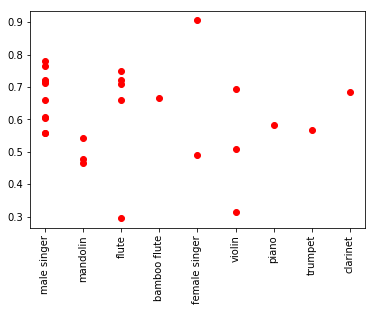

In [67]:
for i, vals in enumerate(oa_vals):
    for v in vals[0]:
        plt.plot(i, v, 'or')

plt.xticks(range(len(inst_vals)), inst_vals, rotation='vertical')